In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import sqlite3

In [2]:
data_path = './movielens-25M/'

In [3]:
if os.path.exists('movies.csv'):
    df_movies = pd.read_csv('movies.csv')
else:
    df_movies = pd.read_csv(data_path + 'movies.csv')
    
    release_years = []
    for i in range(len(df_movies)):
        title = df_movies['title'][i]
        try:
            year = int(title.split('(')[-1][0:-1])
            if year < 1850 or year > 2030:
                year = None
            release_years.append(year)
        except:
            release_years.append(None)
    df_movies['year'] = release_years
    df_movies.to_csv('movies.csv', index = False)
df_movies.loc[0:20]

,movieId,title,genres,year,FirstTimeStamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,822873600.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,822873600.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,823185228.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,823185225.0
4,5,Father of the Bride Part II (1995),Comedy,1995.0,823185224.0
5,6,Heat (1995),Action|Crime|Thriller,1995.0,823185240.0
6,7,Sabrina (1995),Comedy|Romance,1995.0,822873600.0
7,8,Tom and Huck (1995),Adventure|Children,1995.0,823185265.0
8,9,Sudden Death (1995),Action,1995.0,823185248.0
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995.0,822873600.0


In [4]:
if os.path.exists('ratings.csv'):
    df_rating = pd.read_csv('ratings.csv')
else:
    df_rating = pd.read_csv(data_path + 'ratings.csv')
    df_rating = df_rating[df_rating['timestamp']>9.384e8].reset_index(drop=True)
    df_rating.to_csv('ratings.csv', index = False)
df_rating

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
22562555,162541,50872,4.5,1240953372
22562556,162541,55768,2.5,1240951998
22562557,162541,56176,2.0,1240950697
22562558,162541,58559,4.0,1240953434


In [5]:
if not 'FirstTimeStamp' in df_movies.keys():
    first_timestamp_list = []
    for i in tqdm(range(len(df_movies))):
        movieId = df_movies['movieId'][i]
        this_df = df_rating[df_rating['movieId'] == movieId].sort_values('timestamp')
        if len(this_df) > 0:
            first_timestamp_list.append(this_df.iloc[0]['timestamp'])
        else:
            first_timestamp_list.append(None)
    df_movies['FirstTimeStamp'] = first_timestamp_list
    df_movies.to_csv('movies.csv', index = False)
df_movies.sort_values('year')

,movieId,title,genres,year,FirstTimeStamp
35536,148054,Passage de Venus (1874),Documentary,1874.0,1.452568e+09
35533,148048,Sallie Gardner at a Gallop (1878),(no genres listed),1878.0,1.455288e+09
59938,202045,Athlete Swinging a Pick (1880),Documentary,1880.0,1.557705e+09
43771,166800,Buffalo Running (1883),(no genres listed),1883.0,1.482372e+09
35529,148040,Man Walking Around a Corner (1887),(no genres listed),1887.0,1.448835e+09
...,...,...,...,...,...
62071,207714,Tales of Found Footage,(no genres listed),NaN,1.571721e+09
62104,207884,Enduring Destiny,(no genres listed),NaN,1.571970e+09
62285,208597,Punk the Capital: Building a Sound Movement,Documentary,NaN,1.573240e+09
62326,208763,Yosemite: The Fate of Heaven,(no genres listed),NaN,1.573517e+09


In [6]:
if os.path.exists('user.csv'):
    df_user = pd.read_csv('user.csv')
else:
    dict_user = {
        'userId': [],
        'Average Rating': [],
        'First TimeStamp': [],
        'Last TimeStamp': []
    }
    for userId in tqdm(set(df_rating['userId'])):
        dict_user['userId'].append(userId)
        this_df = df_rating[df_rating['userId'] == userId].sort_values('timestamp')
        dict_user['Average Rating'].append(np.mean(this_df['rating']))
        dict_user['First TimeStamp'].append(this_df.iloc[0]['timestamp'])
        dict_user['Last TimeStamp'].append(this_df.iloc[-1]['timestamp'])
    df_user = pd.DataFrame(dict_user)
    df_user.to_csv('user.csv', index = False)
df_user

,userId,Average Rating,First TimeStamp,Last TimeStamp
0,1,3.814286,1.147868e+09,1.147880e+09
1,2,3.630435,1.141416e+09,1.141418e+09
2,3,3.697409,1.439472e+09,1.566092e+09
3,4,3.378099,1.573937e+09,1.574195e+09
4,6,4.153846,9.451415e+08,9.451442e+08
...,...,...,...,...
128694,162537,4.039604,1.047171e+09,1.047172e+09
128695,162538,3.415584,1.438781e+09,1.438786e+09
128696,162539,4.510638,9.951497e+08,9.951508e+08
128697,162540,3.829545,1.248855e+09,1.249030e+09


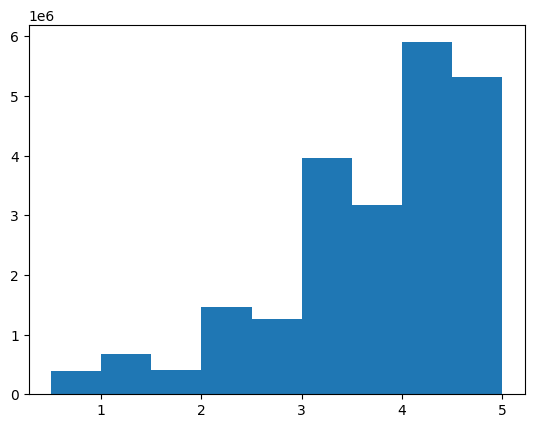

In [7]:
_ = plt.hist(df_rating['rating'],9)

In [8]:
json_path = './'
high_rate_json_path = json_path + 'high_rate_user.json'
low_rate_json_path = json_path + 'low_rate_user.json'
all_rate_json_path = json_path + 'all_rate_user.json'

In [9]:
if os.path.exists(high_rate_json_path):
    with open(high_rate_json_path, 'r') as f:
        high_rate_user_dict = json.load(f)
else:
    high_rate_df = df_rating[df_rating['rating'] > 3.6]
    high_rate_user_dict = {}
    for mov_id in tqdm(set(df_rating['movieId'])):
        high_rate_user_dict[mov_id] = list(high_rate_df[high_rate_df['movieId']==mov_id]['userId'])
    with open('high_rate_user.json', 'w') as f:
        _ = json.dump(high_rate_user_dict, f)

In [10]:
if os.path.exists(low_rate_json_path):
    with open(low_rate_json_path, 'r') as f:
        low_rate_user_dict = json.load(f)
else:
    low_rate_df = df_rating[df_rating['rating'] < 2.9]
    low_rate_user_dict = {}
    for mov_id in tqdm(set(df_rating['movieId'])):
        low_rate_user_dict[mov_id] = list(low_rate_df[low_rate_df['movieId']==mov_id]['userId'])
    with open('low_rate_user.json', 'w') as f:
        _ = json.dump(low_rate_user_dict, f)

In [11]:
if os.path.exists(all_rate_json_path):
    with open(all_rate_json_path, 'r') as f:
        all_rate_user_dict = json.load(f)
else:
    all_rate_user_dict = {}
    for mov_id in tqdm(set(df_rating['movieId'])):
        all_rate_user_dict[mov_id] = list(df_rating[df_rating['movieId']==mov_id]['userId'])
    with open('all_rate_user.json', 'w') as f:
        _ = json.dump(all_rate_user_dict, f)

In [12]:
def liker_ratio(movieId):
    effective_user_list = list(df_user[df_user['Last TimeStamp'] >= df_movies[df_movies['movieId']==movieId]['FirstTimeStamp'].iloc[0]]['userId'])
    return len(high_rate_user_dict[str(movieId)]) / len(effective_user_list)

In [13]:
def condition_rate(mov_id_A, mov_id_B, mov_a_rate='high', mov_b_rate='high', inter=None, debug=False):
    mov_id_A, mov_id_B = str(mov_id_A), str(mov_id_B)
    if mov_a_rate == 'high':
        A_dict = high_rate_user_dict
    elif mov_a_rate == 'low':
        A_dict = low_rate_user_dict
    elif mov_a_rate == 'all':
        A_dict = all_rate_user_dict
    else:
        print("The argument mov_a_rate must be either 'high', 'low', or 'all'.")
        return None

    if mov_b_rate == 'high':
        B_dict = high_rate_user_dict
    elif mov_b_rate == 'low':
        B_dict = low_rate_user_dict
    elif mov_b_rate == 'all':
        B_dict = all_rate_user_dict
    else:
        print("The argument mov_b_rate must be either 'high', 'low', or 'all'.")
        return None
        
    if df_movies[df_movies['movieId']==int(mov_id_B)]['FirstTimeStamp'].iloc[0] > df_movies[df_movies['movieId']==int(mov_id_A)]['FirstTimeStamp'].iloc[0]:
        effective_user_list = list(df_user[df_user['Last TimeStamp'] >= df_movies[df_movies['movieId']==int(mov_id_B)]['FirstTimeStamp'].iloc[0]]['userId'])
        len_a = len(set(A_dict[mov_id_A]).intersection(set(effective_user_list)))
    else:
        len_a = len(A_dict[mov_id_A])
        
    if not (mov_id_A in A_dict.keys() and mov_id_B in B_dict.keys()):
        return 0
    if inter is None:
        inter = len(set(A_dict[mov_id_A]).intersection(set(B_dict[mov_id_B])))
    #len_a = len(A_dict[mov_id_A])
    if debug:
        print(inter, len_a)
    return inter/len_a

In [14]:
def improvement_ratio(mov_id_A, mov_id_B, mov_a_rate='high', mov_b_rate='high', inter=None, debug=False):
    mov_id_A, mov_id_B = str(mov_id_A), str(mov_id_B)
    if mov_a_rate == 'high':
        A_dict = high_rate_user_dict
    elif mov_a_rate == 'low':
        A_dict = low_rate_user_dict
    elif mov_a_rate == 'all':
        A_dict = all_rate_user_dict
    else:
        print("The argument mov_a_rate must be either 'high', 'low', or 'all'.")
        return None
    if mov_b_rate == 'high':
        B_dict = high_rate_user_dict
    elif mov_b_rate == 'low':
        B_dict = low_rate_user_dict
    elif mov_b_rate == 'all':
        B_dict = all_rate_user_dict
    else:
        print("The argument mov_b_rate must be either 'high', 'low', or 'all'.")
        return None
    
    if not (mov_id_A in A_dict.keys() and mov_id_B in B_dict.keys()):
        return 0

    if inter is None:
        inter = len(set(A_dict[mov_id_A]).intersection(set(B_dict[mov_id_B])))
    len_b = len(B_dict[mov_id_B])
    this_condition_rate = condition_rate(mov_id_A, mov_id_B, mov_a_rate=mov_a_rate, mov_b_rate=mov_b_rate, inter=inter)
    if this_condition_rate == 0 or len_b == 0:
        return 0
    effective_user_list = list(df_user[df_user['Last TimeStamp'] >= df_movies[df_movies['movieId']==int(mov_id_B)]['FirstTimeStamp'].iloc[0]]['userId'])
    this_uncondition_rate = len_b/len(effective_user_list)

    if debug:
        print(this_condition_rate, len_b, len(effective_user_list))
    return this_condition_rate / this_uncondition_rate

In [15]:
def reviewer_intersection(mov_id_A, mov_id_B, mov_a_rate='high', mov_b_rate='high'):
    mov_id_A, mov_id_B = str(mov_id_A), str(mov_id_B)
    if mov_a_rate == 'high':
        A_dict = high_rate_user_dict
    elif mov_a_rate == 'low':
        A_dict = low_rate_user_dict
    elif mov_a_rate == 'all':
        A_dict = all_rate_user_dict
    else:
        print("The argument mov_a_rate must be either 'high', 'low', or 'all'.")
        return None

    if mov_b_rate == 'high':
        B_dict = high_rate_user_dict
    elif mov_b_rate == 'low':
        B_dict = low_rate_user_dict
    elif mov_b_rate == 'all':
        B_dict = all_rate_user_dict
    else:
        print("The argument mov_b_rate must be either 'high', 'low', or 'all'.")
        return None
        
    return len(set(A_dict[str(mov_id_A)]).intersection(set(B_dict[str(mov_id_B)])))

In [16]:
def score_compound(mov_id_A, mov_id_B,
                   positive_intersection=None, negative_intersection=None, all_intersection=None):
    if positive_intersection is None:
        positive_intersection = reviewer_intersection(mov_id_A, mov_id_B)
    if negative_intersection is None:
        negative_intersection = reviewer_intersection(mov_id_A, mov_id_B, mov_b_rate='low')
    if all_intersection is None:
        all_intersection = reviewer_intersection(mov_id_A, mov_id_B, mov_b_rate='all')
    positive_boost = improvement_ratio(mov_id_A, mov_id_B, inter=positive_intersection)
    negative_boost = improvement_ratio(mov_id_A, mov_id_B, mov_b_rate='low', inter=negative_intersection)
    positive_condition_prob = condition_rate(mov_id_A, mov_id_B, inter=positive_intersection)
    negative_condition_prob = condition_rate(mov_id_A, mov_id_B, mov_b_rate='low', inter=negative_intersection)
    all_condition_prob = condition_rate(mov_id_A, mov_id_B, mov_b_rate='all', inter=all_intersection)
    return (positive_boost, negative_boost, positive_condition_prob, negative_condition_prob, all_condition_prob)

In [17]:
def movie_title(movie_id):
    return df_movies[df_movies['movieId'] == movie_id]['title'].iloc[0]

In [18]:
def final_score(a=3, b=2, lower_positive_condition=0.1, upper_all_condtion=0.9):
    def func(positive_boost, negative_boost, positive_condition_prob, negative_condition_prob, all_condition_prob):
        if positive_condition_prob < lower_positive_condition or all_condition_prob > upper_all_condtion:
            return -9999
        if negative_boost >= positive_boost or b * negative_condition_prob >= positive_condition_prob:
            return -9999
        return a * np.log(positive_boost / max([1, negative_boost])) / np.log(10) + positive_condition_prob - b * negative_condition_prob
    return func

In [19]:
score_func = final_score()

In [20]:
if os.path.exists('hundred_likers.csv'):
    hundred_likers_df = pd.read_csv('hundred_likers.csv')
else:
    hundred_likers_dict = {'Movie_id': [], 'Movie':[], 'Year': [], 'Liker_num':[], 'Liker_ratio':[]}
    for k, v in tqdm(high_rate_user_dict.items()):
        if len(v) >= 100:
            hundred_likers_dict['Movie_id'].append(int(k))
            hundred_likers_dict['Movie'].append(df_movies[df_movies['movieId'] == int(k)]['title'].iloc[0])
            hundred_likers_dict['Year'].append(df_movies[df_movies['movieId'] == int(k)]['year'].iloc[0])
            hundred_likers_dict['Liker_num'].append(len(v))
            hundred_likers_dict['Liker_ratio'].append(liker_ratio(int(k)))
    hundred_likers_df = pd.DataFrame(likers_dict).sort_values('Liker_ratio', ascending=False)
    hundred_likers_df.to_csv('hundred_likers.csv', index=False)
hundred_likers_df.iloc[0:50]

,Movie_id,Movie,Year,Liker_num,Liker_ratio
0,79132,Inception (2010),2010.0,29620,0.458337
1,318,"Shawshank Redemption, The (1994)",1994.0,56381,0.438084
2,2571,"Matrix, The (1999)",1999.0,55485,0.431122
3,58559,"Dark Knight, The (2008)",2008.0,32215,0.429384
4,4993,"Lord of the Rings: The Fellowship of the Ring,...",2001.0,41529,0.384268
5,7153,"Lord of the Rings: The Return of the King, The...",2003.0,37674,0.379029
6,296,Pulp Fiction (1994),1994.0,48321,0.375457
7,2959,Fight Club (1999),1999.0,46856,0.365697
8,5952,"Lord of the Rings: The Two Towers, The (2002)",2002.0,37666,0.362672
9,109487,Interstellar (2014),2014.0,16435,0.356453


In [21]:
if os.path.exists('best_300.csv'):
    best_300_df = pd.read_csv('best_300.csv')
else:
    best_300_df = hundred_likers_df.iloc[0:200]
    best_300_df.to_csv('best_300.csv', index=False)
best_300_df

,Unnamed: 0,Movie_id,Movie,Year,Liker_num,Liker_ratio,Taiwan Film Name
0,0,79132,Inception,2010,29620,0.458337,全面啟動
1,1,318,The Shawshank Redemption,1994,56381,0.438084,刺激1995
2,2,2571,The Matrix,1999,55485,0.431122,駭客任務
3,3,58559,The Dark Knight,2008,32215,0.429384,黑暗騎士
4,4,4993,The Lord of the Rings: The Fellowship of the Ring,2001,41529,0.384268,魔戒首部曲：魔戒現身
...,...,...,...,...,...,...,...
295,295,2797,Big,1988,10532,0.081834,飛進未來
296,296,97938,Life of Pi,2012,4368,0.081624,少年Pi的奇幻漂流
297,297,1079,A Fish Called Wanda,1988,10476,0.081399,笨賊一籮筐
298,298,122892,Avengers: Age of Ultron,2015,3659,0.081158,復仇者聯盟2


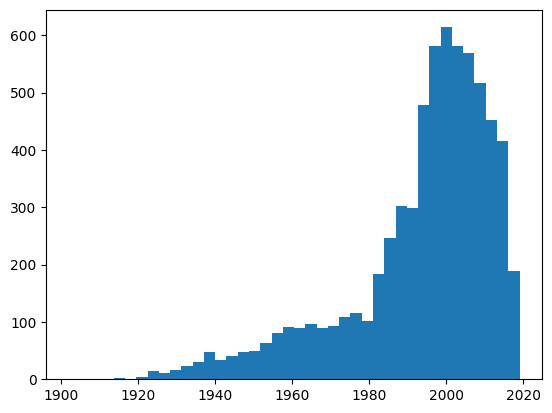

In [22]:
_ = plt.hist(hundred_likers_df['Year'], 40)

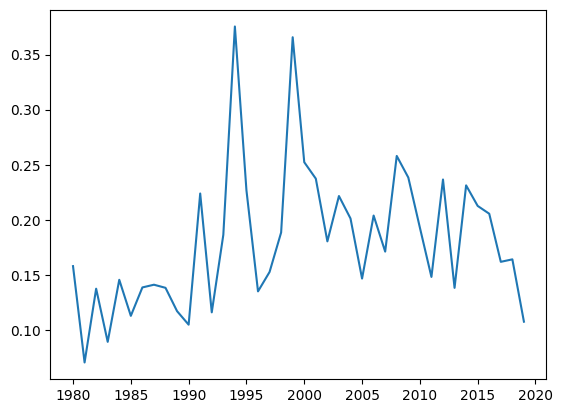

In [23]:
highest_liker_each_year = []
for year in range(1980, 2020):
    highest_liker_each_year.append(np.median(hundred_likers_df[hundred_likers_df['Year'] == year].sort_values('Liker_ratio', ascending=False).iloc[0:3]['Liker_ratio']))

_ = plt.plot([*range(1980,2020)], highest_liker_each_year)

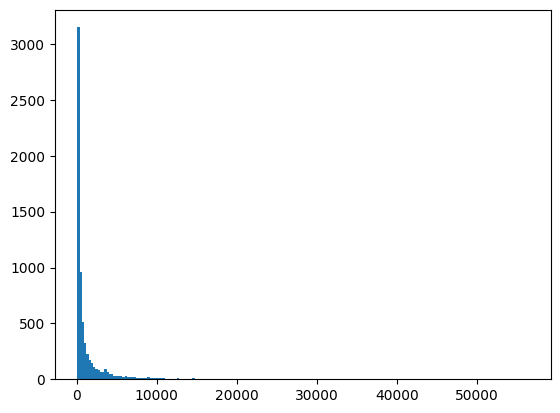

In [24]:
_ = plt.hist(hundred_likers_df['Liker_num'], 200)

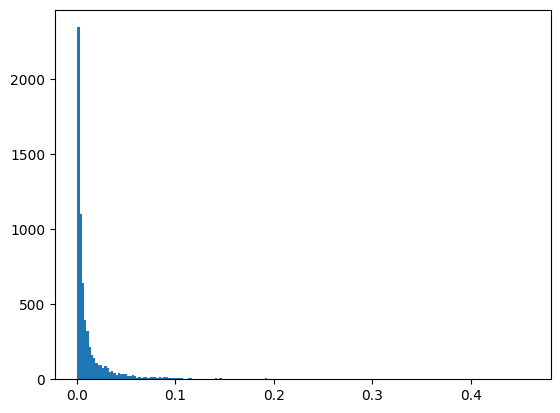

In [25]:
_ = plt.hist(hundred_likers_df['Liker_ratio'], 200)

In [26]:
j = 122904
print(df_movies[df_movies['movieId'] == j].iloc[0]['title'])
print(f'{len(high_rate_user_dict[str(j)])} reviewers gave this movie high scores >= 4.')
print(f'{len(low_rate_user_dict[str(j)])} reviewers gave this movie low scores < 3.')
movie_list = []
ir_list = []
condition_list = []
score_list = []
a = 3 # boost rate 的權重
b = 0.9 # 條件機率下，最多容許有多少比例的 reviewer 看過這部電影
for i in tqdm(hundred_likers_df['Movie_id']):
    if not i == j:
        positive_boost, negative_boost, positive_condition_prob, negative_condition_prob, all_condition_prob = score_compound(j, i)
        movie_list.append(df_movies[df_movies['movieId'] == i].iloc[0]['title'])
        ir_list.append(positive_boost / max(1, negative_boost))
        condition_list.append(positive_condition_prob - 2 * negative_condition_prob)
        score_list.append(score_func(positive_boost, negative_boost, positive_condition_prob, negative_condition_prob, all_condition_prob))
                

print('=' * 20 + 'List of suggestion' + '=' * 20)
for i in np.argsort(score_list)[-1::-1][0:min(100, len(score_list))]:
    print(f"{df_movies[df_movies['title'] == movie_list[i]]['movieId'].iloc[0]} {movie_list[i]}: {ir_list[i]:.2f}, {condition_list[i] * 100:.2f}%, {score_list[i]:.4f}")

Deadpool (2016)
8795 reviewers gave this movie high scores >= 4.
1685 reviewers gave this movie low scores < 3.


100%|██████████████████████████████████████████████████████████████████████████████| 6698/6698 [01:44<00:00, 64.12it/s]


====================List of suggestion====================
187593 Deadpool 2 (2018): 2.76, 42.73%, 1.7506
112852 Guardians of the Galaxy (2014): 2.41, 51.73%, 1.6651
89745 Avengers, The (2012): 2.46, 37.71%, 1.5521
122918 Guardians of the Galaxy 2 (2017): 2.68, 25.33%, 1.5358
59315 Iron Man (2008): 2.31, 43.70%, 1.5263
119145 Kingsman: The Secret Service (2015): 2.58, 29.18%, 1.5243
122916 Thor: Ragnarok (2017): 2.72, 21.08%, 1.5169
122912 Avengers: Infinity War - Part I (2018): 2.59, 21.09%, 1.4485
122922 Doctor Strange (2016): 2.54, 22.21%, 1.4352
122920 Captain America: Civil War (2016): 2.51, 21.88%, 1.4190
122914 Avengers: Infinity War - Part II (2019): 2.71, 10.22%, 1.3997
110102 Captain America: The Winter Soldier (2014): 2.44, 22.24%, 1.3854
91529 Dark Knight Rises, The (2012): 2.07, 43.64%, 1.3834
122892 Avengers: Age of Ultron (2015): 2.52, 16.07%, 1.3640
122926 Untitled Spider-Man Reboot (2017): 2.50, 15.53%, 1.3502
111362 X-Men: Days of Future Past (2014): 2.33, 21.81%, 1.3

In [116]:
cross_database_path = './cross_scores.db'
conn = sqlite3.connect(cross_database_path)
cursor = conn.cursor()
cursor.execute(
    (
        'CREATE TABLE IF NOT EXISTS cross_score('
        'Movie_ID_A INT,'
        'Movie_ID_B INT,'
        'Positive_Boost FLOAT,'
        'Negative_Boost FLOAT,'
        'Positive_Condition_Prob FLOAT,'
        'Negative_Condition_Prob FLOAT,'
        'ALL_Condition_Prob FLOAT,'
        'Final_Score FLOAT)'
        ';'
    )
)

for i in tqdm(best_300_df['Movie_id']):
    cursor.execute(f'SELECT * FROM cross_score WHERE Movie_ID_A = {i}')
    if len(cursor.fetchall()) == len(hundred_likers_d) - 1:
        continue
    for j in hundred_likers_df['Movie_id']:
        if not i == j:
            positive_boost, negative_boost, positive_condition_prob, negative_condition_prob, all_condition_prob = score_compound(i, j)
            final_score = score_func(positive_boost, negative_boost, positive_condition_prob, negative_condition_prob, all_condition_prob)
            sql_command = (
                'INSERT INTO cross_score VALUES('
                f'{i}, {j}, {positive_boost:.4f}, {negative_boost:.4f}, {positive_condition_prob:.4f}, {negative_condition_prob:.4f}, {all_condition_prob:.4f}, {final_score:.4f})'
                ';'
            )
            cursor.execute(sql_command)
    conn.commit()


100%|████████████████████████████████████████████████████████████████████████████| 200/200 [12:47:04<00:00, 230.12s/it]
